In [66]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
import pickle

## Load data

In [106]:
k_scale = 0.1
results_folder = f'asd_only_louvain_results_knn_weighted/k_scale_{k_scale}'

def get_cluster_df(sample_size, i, drop_asd = True, drop_index = True):
    folder_path = f"{results_folder}/{sample_size}/{i}"
    df = pd.read_pickle(f"{folder_path}/sample_df.pkl")
    if drop_index:
        df = df.drop("index", axis=1)
    score_cols = ['dcdq_score', 'rbsr_score', 'scq_score']
    df = df.drop(score_cols, axis=1)
    if drop_asd:
        df = df.drop("asd", axis=1)
    return df

def get_communinies(sample_size, i ):
    folder_path = f"{results_folder}/{sample_size}/{i}"
    with open(f"{folder_path}/communities.pkl", 'rb') as file:
        communities = pickle.load(file)
    return communities

In [68]:
spark_df = get_cluster_df(22274, 0)
spark_communities = get_communinies(22274, 0)

In [102]:
spark_df

,dev_lang,dev_lang_dis,sex,attn_behav,dev_speech,dev_soc_prag,birth_oth_calc,dev_motor,behav_adhd,dev_ld,...,mood_dmd,mood_bipol,multiple_birth,mood_or_anx,gen_dx_oth_calc_self_report,mood_hoard,behav_intermitt_explos,behav_conduct,dev_mutism,cluster
0,1.0,0.0,1,0.0,0.0,1.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,1.0,0,0.0,0.0,0.0,0.0,3
2,1.0,1.0,0,1.0,0.0,1.0,0,0.0,1.0,1.0,...,0.0,0.0,0,1.0,0,0.0,0.0,0.0,0.0,1
3,1.0,1.0,1,0.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,2
4,1.0,1.0,1,1.0,0.0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22269,0.0,0.0,1,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,3
22270,1.0,0.0,1,1.0,0.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,4
22271,1.0,1.0,1,0.0,1.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,2
22272,1.0,1.0,1,1.0,0.0,0.0,0,0.0,1.0,1.0,...,0.0,0.0,1,1.0,0,0.0,0.0,0.0,0.0,1


In [69]:
print(len(spark_communities))

5


In [70]:
# check check number of null values in each field
spark_df.apply(lambda x: x.isnull().sum())

dev_lang                       0
dev_lang_dis                   0
sex                            0
attn_behav                     0
dev_speech                     0
dev_soc_prag                   0
birth_oth_calc                 0
dev_motor                      0
behav_adhd                     0
dev_ld                         0
neuro_oth_calc                 0
psych_oth_calc                 0
behav_odd                      0
mood_dep                       0
mood_soc_anx                   0
mood_anx                       0
mood_ocd                       0
mood_sep_anx                   0
mood_dmd                       0
mood_bipol                     0
multiple_birth                 0
mood_or_anx                    0
gen_dx_oth_calc_self_report    0
mood_hoard                     0
behav_intermitt_explos         0
behav_conduct                  0
dev_mutism                     0
cluster                        0
dtype: int64

In [71]:
# create dataset
# target_var = 'asd'
target_var = 'cluster'
feature_space = spark_df.iloc[:, spark_df.columns != 'cluster']
feature_class = spark_df.iloc[:, spark_df.columns == 'cluster']

# train_test_split in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)
# X_train, X_test, y_train, y_test

# Cleaning test sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()

In [72]:
set(y_train)

{0, 1, 2, 3, 4}

In [73]:
from collections import Counter

def print_value_counts(y, dataset_name):
    counter = Counter(y)
    total = len(y)
    print(f"Value counts for {dataset_name}:")
    for value in sorted(counter.keys()):  # Sort the keys before iterating
        count = counter[value]
        percentage = (count / total) * 100
        print(f"Value {value}: {count} times ({percentage:.2f}%)")
    print()

print_value_counts(y_train, "y_train")
print_value_counts(y_test, "y_test")

Value counts for y_train:
Value 0: 2849 times (15.99%)
Value 1: 4209 times (23.62%)
Value 2: 5052 times (28.35%)
Value 3: 3024 times (16.97%)
Value 4: 2685 times (15.07%)

Value counts for y_test:
Value 0: 742 times (16.66%)
Value 1: 1077 times (24.18%)
Value 2: 1246 times (27.97%)
Value 3: 777 times (17.44%)
Value 4: 613 times (13.76%)



In [74]:
# instantiate classifier 
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=10)

## Parameter grid search

In [75]:
# np.random.seed(42)
# start = time.time()

# # give to GridSearchCV

# param_dist = {'max_depth': [5, 10, 20],
#  'bootstrap': [True, False],
#  'max_features': ['sqrt', 'log2'],
#  'criterion': ['gini', 'entropy'],
#  'n_estimators': [20, 100, 200]}

# # param_dist = {'max_depth': [5, 20],
# #  'bootstrap': [True],
# #  'max_features': ['sqrt'],
# #  'criterion': ['gini'],
# #  'n_estimators': [20]}

# param_dist = {'max_depth': [2, 5, 10, 20, None],
#  'bootstrap': [True, False],
#  'max_features': ['sqrt', 'log2'],
#  'criterion': ['gini', 'entropy'],
#  'n_estimators': [10, 20, 40, 80, 100, 200, 500]}

# # set up the GridSearch
# cv_rf = GridSearchCV(rf_classifier, cv = 5,
#                      param_grid=param_dist, 
#                      n_jobs = 3, return_train_score=True)

# # fit the GridSearch
# cv_rf.fit(X_train, y_train)
# print('Best Parameters using grid search: \n', cv_rf.best_params_)


# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

In [76]:
# print("Best parameters:", cv_rf.best_params_)
# print("Best score:", cv_rf.best_score_)

In [77]:
# cv_rf.cv_results_['mean_train_score'][cv_rf.best_index_]

In [78]:
# cv_results = cv_rf.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print("Mean Score:", mean_score)
#     print("Parameters:", params)
#     print("---")

In [79]:
# with open('cv_rf_more_features.pickle', 'rb') as file:
#     # Unpickle the object
#     cv = pickle.load(file)

## Fitting best classifier

In [80]:
best_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 40}
rf_classifier.set_params(**best_params)
# best score: 1

# rf_classifier.set_params(**cv_rf.best_params_)


RandomForestClassifier(max_depth=5, n_estimators=40, random_state=42)

In [81]:
# fit the Random forest to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=40, random_state=42)

In [82]:
# returns a dict with value pairs {importance: indices} for printing
def variable_importance(fit):
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Checks whether model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    # sort from most import to least
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [83]:
# get variable importance and their indexes
rf_var_imp = variable_importance(rf_classifier)

rf_importances = rf_var_imp['importance']

rf_indices = rf_var_imp['index']

In [256]:
names_index = X_train.columns
sorted_feature_names = [names_index[i] for i in rf_indices]
sorted_improtances = [rf_importances[i] for i in rf_indices]
sorted_feature_importances_df = pd.DataFrame({'feature': sorted_feature_names, 'importance': sorted_improtances})
sorted_feature_importances_df
# pd.to_pickle(sorted_feature_importances_df, 'sorted_feature_importances_asd_only.pkl')


In [85]:
# unpacks and prints values in importance dict according to the index 
def print_var_importance(importance, indices, names_index=X_train.columns):
    print("Feature ranking:")
    # iterate thru variable indices
    for f in range(0, indices.shape[0]):
        i = f
        # prints the name of the feature and its importance metric 
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1, names_index[indices[i]], importance[indices[f]]))

In [86]:
# get the classes uses to train this model
names_index = feature_space.columns
# names_index = names[2:]

# print out classes by importance in decending order
print_var_importance(rf_importances, rf_indices)

Feature ranking:
1. The feature 'dev_lang_dis' has a Mean Decrease in Impurity of 0.25500
2. The feature 'attn_behav' has a Mean Decrease in Impurity of 0.24391
3. The feature 'dev_lang' has a Mean Decrease in Impurity of 0.19362
4. The feature 'behav_adhd' has a Mean Decrease in Impurity of 0.16257
5. The feature 'dev_speech' has a Mean Decrease in Impurity of 0.04611
6. The feature 'dev_ld' has a Mean Decrease in Impurity of 0.02506
7. The feature 'dev_soc_prag' has a Mean Decrease in Impurity of 0.01783
8. The feature 'dev_motor' has a Mean Decrease in Impurity of 0.01670
9. The feature 'mood_or_anx' has a Mean Decrease in Impurity of 0.01178
10. The feature 'behav_odd' has a Mean Decrease in Impurity of 0.01162
11. The feature 'mood_anx' has a Mean Decrease in Impurity of 0.00455
12. The feature 'mood_dep' has a Mean Decrease in Impurity of 0.00299
13. The feature 'mood_ocd' has a Mean Decrease in Impurity of 0.00166
14. The feature 'mood_soc_anx' has a Mean Decrease in Impurity of

### Feature importance

In [87]:
# Make a horizontal bar chart to visualize feature importantance

def variable_importance_plot(importance, indices, names_index=X_train.columns, save_path=None):
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)

    feature_space = []

    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 6))

    plt.title('Feature importances for Random Forest model')
    
    plt.barh(index,
              importance_desc,
              align="center",
              color = '#FFB6C1')
    plt.yticks(index,
                feature_space)

    # plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean decrease in impurity')
    plt.ylabel('Feature')
    plt.grid(True, axis='x')

    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    # plt.savefig('./figures/feature_importance_RF_mf_newest.pdf')

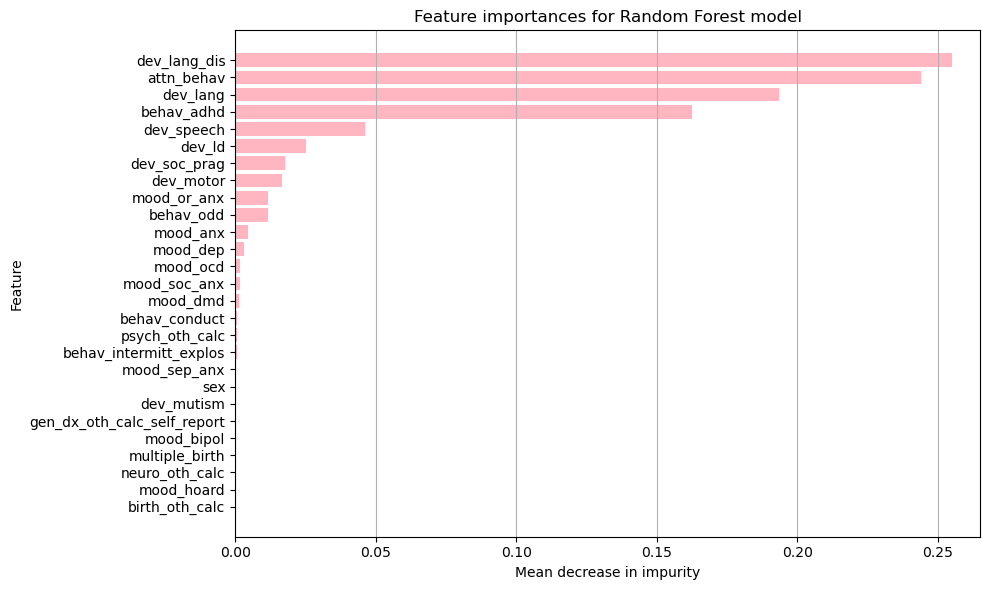

In [88]:
# variable_importance_plot(rf_importances, rf_indices, save_path='./figures/feature_importance_ASD_subgroups_asd_only_weighted.pdf')
variable_importance_plot(rf_importances, rf_indices)

### Cross validation

In [89]:
# Perform Cross_validation to see how robust our model is 
import time

def cross_val_metrics(fit, X_train, y_train, estimator, print_results = True):
    start = time.time()
    """
    Returns Mean Accurancy with standard_dev of model over Kfolds Validation
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Checks whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
              \nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    # create KFolds validation
    n = KFold(n_splits=10)

    # record score for each split
    scores = cross_val_score(fit, 
                         X_train, 
                         y_train, 
                         cv = n)
    end = time.time() 
    # print how much time the Kfolds took
    print("Time elapsed to do Cross Validation: {0:.2f} seconds.".format(end-start))
    if print_results:
        for i in range(0, len(scores)):
            # print out the scores for each validation split
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))

        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})".format(scores.mean(), scores.std() / 2))     
    else:
        return scores.mean(), scores.std() / 2

In [90]:
# call cross_val_metrics to see how our model did
cross_val_metrics(rf_classifier, 
                  X_train, 
                  y_train, 
                  'rf',
                  print_results = True)

Time elapsed to do Cross Validation: 1.19 seconds.
Cross validation run 0:  1.000
Cross validation run 1:  1.000
Cross validation run 2:  1.000
Cross validation run 3:  1.000
Cross validation run 4:  1.000
Cross validation run 5:  1.000
Cross validation run 6:  1.000
Cross validation run 7:  1.000
Cross validation run 8:  1.000
Cross validation run 9:  1.000
Accuracy:  1.000 (+/-  0.000)


In [91]:
# make a prediction on test set now that the model has been tuned and validated
rf_predictions = rf_classifier.predict(X_test)

In [92]:

def create_conf_mat(y_test, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(y_test.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics; Compute a simple cross tabulation of two (or more) factors. 
        # By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
        test_crosstb_comp = pd.crosstab(index = y_test,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

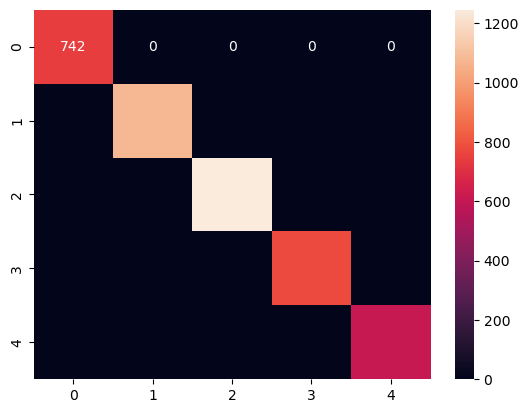

array([[ 742,    0,    0,    0,    0],
       [   0, 1077,    0,    0,    0],
       [   0,    0, 1246,    0,    0],
       [   0,    0,    0,  777,    0],
       [   0,    0,    0,    0,  613]])

In [93]:
conf_mat = create_conf_mat(y_test, rf_predictions)

# use seaborn heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=True)
# plt.xlabel('Predicted Values')
# plt.ylabel('Actual Values')
# plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

conf_mat


## Test set performance

In [94]:
# use built in score function to get accurancy of this model against the test set
rf_accuracy = rf_classifier.score(X_test, y_test)

print("Here is our mean accuracy on the test set:\n {0:.4f}"\
      .format(rf_accuracy))

Here is our mean accuracy on the test set:
 1.0000


In [95]:
# Here we calculate the test error rate!
rf_test_error_rate = 1 - rf_accuracy
print("The test error rate for our model is:\n {0: .4f}"\
      .format(rf_test_error_rate))

The test error rate for our model is:
  0.0000


In [96]:
# predict_proba returns two arrays that represent the predicted_prob of negative class and positive class respectively.

# I just want to take the positive classes in this instance
predictions_prob = rf_classifier.predict_proba(X_test)[:, 1]

# use roc_curve to produce 
fpr2, tpr2, _ = roc_curve(y_test,
                          predictions_prob,
                          pos_label = 1)

auc_rf = auc(fpr2, tpr2)

print(auc_rf)

1.0


## Running on all ASD data

### Getting all data

In [113]:
spark_df_all = pd.read_csv('./spark_cleaned_data_more_features.csv')

# id_cols = ['subject_sp_id', 'respondent_sp_id', 'family_id', 'biomother_id','biofather_id']
id_cols = ['respondent_sp_id', 'family_id', 'biomother_id','biofather_id']
race_cols = ['race_asian','race_african_amer', 'race_native_amer', 'race_native_hawaiian',
       'race_white', 'race_other', 'hispanic']

spark_df_all = spark_df_all.drop(id_cols, axis=1)
# spark_df_all  = spark_df_all.drop(age_cols, axis=1)
spark_df_all  = spark_df_all.drop(race_cols, axis=1)

In [133]:
spark_df_asd_only_clusters = get_cluster_df(22274, 0, drop_index=False)
# need this to get the subject_sp_id
spark_df_asd_only = pd.read_csv('./spark_cleaned_more_features_asd_final_scores.csv')

# Reset the index of spark_df_asd_only_ids to make it a column
spark_df_asd_only_ids = spark_df_asd_only['subject_sp_id'].reset_index()
# add id to the cluster df
spark_df_asd_only_clusters = pd.merge(spark_df_asd_only_clusters, spark_df_asd_only_ids, on='index')



In [145]:
clustered_ids = spark_df_asd_only_clusters['subject_sp_id'].to_list()

In [148]:
unseen_asd_df = spark_df_all[(~spark_df_all['subject_sp_id'].isin(clustered_ids)) & (spark_df_all['asd'] == 1)]
unseen_asd_df = unseen_asd_df.drop(['asd', 'subject_sp_id'], axis=1)
# get features in same order as model
unseen_asd_df = unseen_asd_df[X_train.columns]

In [149]:
print(unseen_asd_df.shape)
unseen_asd_df.columns

# X_train.columns

(29626, 27)


Index(['dev_lang', 'dev_lang_dis', 'sex', 'attn_behav', 'dev_speech',
       'dev_soc_prag', 'birth_oth_calc', 'dev_motor', 'behav_adhd', 'dev_ld',
       'neuro_oth_calc', 'psych_oth_calc', 'behav_odd', 'mood_dep',
       'mood_soc_anx', 'mood_anx', 'mood_ocd', 'mood_sep_anx', 'mood_dmd',
       'mood_bipol', 'multiple_birth', 'mood_or_anx',
       'gen_dx_oth_calc_self_report', 'mood_hoard', 'behav_intermitt_explos',
       'behav_conduct', 'dev_mutism'],
      dtype='object')

### Predicting subgroups on new data with current RF classifier

In [150]:

cluster_predictions = rf_classifier.predict(unseen_asd_df)

# plot distribution of labels

In [251]:
def plot_cluster_distribution(cluster_predictions, save_path=None):

    cluster_predictions_series = pd.Series(cluster_predictions)
    class_counts = cluster_predictions_series.value_counts(normalize=True) * 100
    class_counts_sorted = class_counts.sort_index()
    print(class_counts_sorted)

    # Generate a color palette
    # colors = plt.cm.Accent(np.linspace(0, 1, len(class_counts_sorted)))
    # colors = plt.cm.Paired([0, 1,3,2,6])
    colors = plt.cm.Accent([0, 1,3,2,6])
    # colors = plt.cm.tab10([0, 1,2,3,4])
    # colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts_sorted)))

    plt.figure(figsize=(5.5, 4))

    # Create the pie chart without labels
    wedges, texts, autotexts = plt.pie(class_counts_sorted, autopct='%1.1f%%', startangle=90, colors=colors, counterclock=False)

    # Add a legend with labels starting from zero
    plt.legend(wedges, [f'Cluster {i+1}' for i in class_counts_sorted.index], loc="best")

    plt.title('Distribution of ASD clusters\n across all ASD individuals (n = 51900)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)

In [235]:
# plot_cluster_distribution(cluster_predictions)

In [232]:
all_cluster_labels = np.concatenate((y_train, y_test, cluster_predictions))
print(len(all_cluster_labels))

51900


0    14.851638
1    21.894027
2    29.890173
3    18.949904
4    14.414258
Name: proportion, dtype: float64


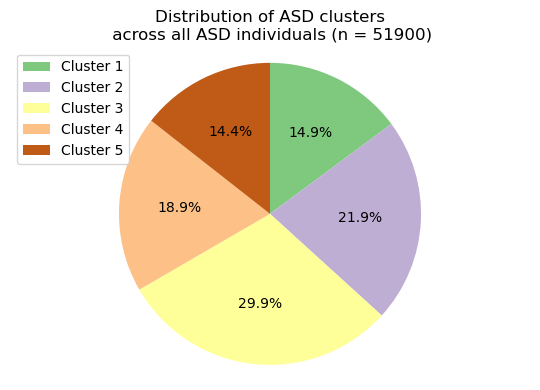

In [254]:

# plot_cluster_distribution(all_cluster_labels, './figures/asd_only_cluster_distribution.pdf')
plot_cluster_distribution(all_cluster_labels)